### Imports & Options

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from os import listdir
from pathlib import Path

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

## Process
For reference, this [helpful diagram](https://xang1234.github.io/images/isochrone/gtfs.png) explains how the tables in GTFS data are linked together.

For both the train and the bus, I need to know the average travel time between stops for each route that stops at those stops. For example, if riding the bus on Ashland Ave, I need to know the average travel times between stops, both if taking the local 9 bus or the express X9 bus.

The table `stop_times.txt` contains all the times a bus or train stops at a stop, as well as a `stop_sequence` number that records the order of stops along a trip. I belive that a trip, denoted by `trip_id`, is a trip taken by a single bus or train. For example, the 9 bus has 1838 unique trips.

From the trip that each bus takes, or is scheduled to take, I can determine the average travel time between stops. I could also determine the estimated travel time between stops depending on the time of day, but for this MVP let's start with just the average time. I say estimated travel time because this is not real-time bus data, it is the published schedules. Anyone who has ridden the bus in Chicago knows that the schedule is a joke. But while the bus may not actually arrive when it's supposed to, I think this data is a reliable estimation of how long it takes to get from stop to stop once the bus arrives. I know the CTA has taken great care to try and publish schedules that match congestion patterns, and so I think it's safe to trust their measurements of of bus speeds. Regardless, this project is to test the effect of bus frequency on travel times, not bus speeds. That will be for a later project.

And so, let's use the `stop_times.txt` dataset to group stops by trip and determine average travel times.

### To-Do
- Done: Travel times from the previous stop.
- Next: For each stop, all the other stops you can get to an how long it would take.

## Data

In [5]:
filepath = Path("data/us-illinois-chicago-transit-authority-cta-gtfs-389/")
listdir(filepath)

['transfers.txt',
 'agency.txt',
 'calendar_dates.txt',
 'stop_times.txt',
 'frequencies.txt',
 'shapes.txt',
 'trips.txt',
 'stops.txt',
 'calendar.txt',
 'routes.txt']

In [6]:
# Needed tables
stop_times = pd.read_csv(filepath / Path("stop_times.txt"))
trips = pd.read_csv(filepath / Path("trips.txt"))
stop_times = stop_times.merge(trips, how="left", on="trip_id")

stops = pd.read_csv(filepath / Path("stops.txt"))
# routes = pd.read_csv(filepath / Path("routes.txt"))

#### Cleaning

Stop arrival and depart times are strings. Convert to datetime.

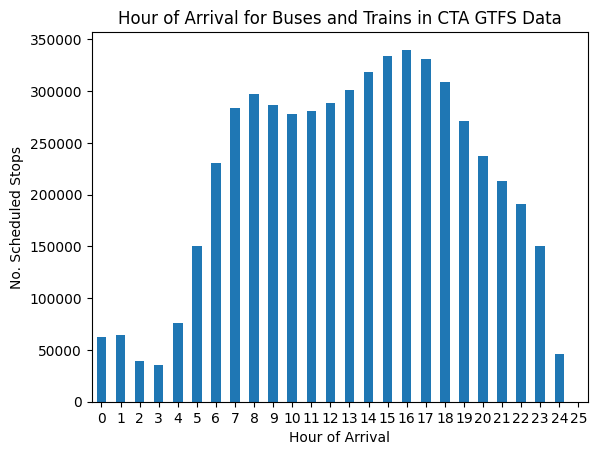

In [7]:
# Damn, CTA, you have both 0th hour and 24th and 25th hour arrival times.
# That makes sense, for trips that start before midnight and run after.
stop_times["arrival_time"].apply(lambda ts: int(ts.split(":")[0])) \
    .value_counts().sort_index().plot.bar()
plt.title("Hour of Arrival for Buses and Trains in CTA GTFS Data")
plt.xlabel("Hour of Arrival")
plt.ylabel("No. Scheduled Stops")
plt.xticks(rotation=0);
plt.savefig("plots/Hour of Arrivals.png", facecolor="white", dpi=200, bbox_inches='tight')

Ok, because dealing with times at the 0th and 25th hour will be a pain, let's look at just 5 AM through midnight. This at least looks to be when service is most active.

In [8]:
# Filtering this way will cut off trips before they finish.
# After 5 AM and before 12 PM
stop_times["hour_of_arrival"] = stop_times["arrival_time"].apply(lambda ts: int(ts.split(":")[0]))
stop_times = stop_times[(stop_times["hour_of_arrival"] >= 5) & (stop_times["hour_of_arrival"] < 24)]

In [9]:
# This artifically makes every stop time on Jan. 1 1900, but we'll be ignoring the date
_format = "%H:%M:%S"
stop_times["arrival_time"] = pd.to_datetime(stop_times["arrival_time"], format=_format)
stop_times["departure_time"] = pd.to_datetime(stop_times["departure_time"], format=_format)

#### Let's start by investigating one bus trip

In [10]:
# How many unique `trips` are there for the Ashland local route?
ashland_trips = trips[trips["route_id"] == "9"]["trip_id"].value_counts()
ashland_trips.shape[0]

1838

In [11]:
ashland_stop_times = stop_times[stop_times["trip_id"].isin(ashland_trips.index)]
ashland_stop_times

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,shape_dist_traveled,route_id,service_id,direction_id,block_id,shape_id,direction,wheelchair_accessible,schd_trip_id,hour_of_arrival
5379927,6490048291010,1900-01-01 20:00:00,1900-01-01 20:00:00,6131,1,Irving Park,0,0,9,64909,1.0,6.490000e+11,64909372,North,1.0,48291010,20
5379928,6490048291010,1900-01-01 20:00:15,1900-01-01 20:00:15,6147,2,Irving Park,0,628,9,64909,1.0,6.490000e+11,64909372,North,1.0,48291010,20
5379929,6490048291010,1900-01-01 20:00:25,1900-01-01 20:00:25,6148,3,Irving Park,0,1021,9,64909,1.0,6.490000e+11,64909372,North,1.0,48291010,20
5379930,6490048291010,1900-01-01 20:00:41,1900-01-01 20:00:41,6149,4,Irving Park,0,1684,9,64909,1.0,6.490000e+11,64909372,North,1.0,48291010,20
5379931,6490048291010,1900-01-01 20:01:41,1900-01-01 20:01:41,14781,5,Irving Park,0,3191,9,64909,1.0,6.490000e+11,64909372,North,1.0,48291010,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5409231,6490048410070,1900-01-01 11:34:28,1900-01-01 11:34:28,6126,77,95th,0,86911,9,64906,0.0,6.490000e+11,64901600,South,1.0,48410070,11
5409232,6490048410070,1900-01-01 11:35:45,1900-01-01 11:35:45,6128,78,95th,0,88228,9,64906,0.0,6.490000e+11,64901600,South,1.0,48410070,11
5409233,6490048410070,1900-01-01 11:36:24,1900-01-01 11:36:24,6129,79,95th,0,88903,9,64906,0.0,6.490000e+11,64901600,South,1.0,48410070,11
5409234,6490048410070,1900-01-01 11:37:09,1900-01-01 11:37:09,6130,80,95th,0,89543,9,64906,0.0,6.490000e+11,64901600,South,1.0,48410070,11


In [12]:
# But hold up, there are only 14 unique trips among the stop times for the ashland bus.
# Why is that?
ashland_stop_times["trip_id"].value_counts().shape[0]

11

In [13]:
# I guess let's start with the stip that visits the most stops
test_trip = ashland_stop_times["trip_id"].value_counts().index[0]
single_trip = ashland_stop_times[ashland_stop_times["trip_id"] == test_trip]
single_trip

# This is a southbound local Ashland bus

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,shape_dist_traveled,route_id,service_id,direction_id,block_id,shape_id,direction,wheelchair_accessible,schd_trip_id,hour_of_arrival
5403900,6500048509050,1900-01-01 14:15:30,1900-01-01 14:15:30,1931,1,104th/Vincennes,0,0,9,65024,0.0,6.500000e+11,65009718,South,1.0,48509050,14
5403901,6500048509050,1900-01-01 14:17:27,1900-01-01 14:17:27,15275,2,104th/Vincennes,0,1594,9,65024,0.0,6.500000e+11,65009718,South,1.0,48509050,14
5403902,6500048509050,1900-01-01 14:18:19,1900-01-01 14:18:19,5681,3,104th/Vincennes,0,2340,9,65024,0.0,6.500000e+11,65009718,South,1.0,48509050,14
5403903,6500048509050,1900-01-01 14:19:19,1900-01-01 14:19:19,5995,4,104th/Vincennes,0,3000,9,65024,0.0,6.500000e+11,65009718,South,1.0,48509050,14
5403904,6500048509050,1900-01-01 14:21:28,1900-01-01 14:21:28,5997,5,104th/Vincennes,0,4187,9,65024,0.0,6.500000e+11,65009718,South,1.0,48509050,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5404814,6500048509050,1900-01-01 16:07:58,1900-01-01 16:07:58,18079,85,104th/Vincennes,0,92370,9,65024,0.0,6.500000e+11,65009718,South,1.0,48509050,16
5404815,6500048509050,1900-01-01 16:09:18,1900-01-01 16:09:18,6136,86,104th/Vincennes,0,93257,9,65024,0.0,6.500000e+11,65009718,South,1.0,48509050,16
5404816,6500048509050,1900-01-01 16:09:45,1900-01-01 16:09:45,6137,87,104th/Vincennes,0,93765,9,65024,0.0,6.500000e+11,65009718,South,1.0,48509050,16
5404817,6500048509050,1900-01-01 16:10:44,1900-01-01 16:10:44,6138,88,104th/Vincennes,0,95023,9,65024,0.0,6.500000e+11,65009718,South,1.0,48509050,16


In [14]:
# How many stops does it make?
single_trip["stop_id"].value_counts().shape[0]

89

In [15]:
# As expected, it stops at each stop only once.
all(single_trip["stop_id"].value_counts() == 1)

True

#### Ok, let's compute the travel time between stops.

In [16]:
# For this bus, scheduled arrival and departure time are the same, down to the second!
# Let's compute travel times between `arrival_times`, since I don't know if those are 
# always equal. Perhaps for trains they are not
all(single_trip["arrival_time"] == single_trip["departure_time"])

True

In [17]:
# Actually, they are always equal. What's the point of departure times then?
all(stop_times["arrival_time"] == stop_times["departure_time"])

True

In [18]:
# sort by stop sequence just to be safe
single_trip = single_trip.sort_values(by="stop_sequence")
single_trip["previous_stop_arrival_time"] = single_trip["arrival_time"].shift(1)
single_trip["previous_stop_id"] = single_trip["stop_id"].shift(1)

In [19]:
single_trip["travel_time_delta"] = single_trip["arrival_time"] - single_trip["previous_stop_arrival_time"]
single_trip.dropna(inplace=True)
single_trip["travel_time_minutes"] = single_trip["travel_time_delta"].apply(lambda td: td.seconds/60)
single_trip

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,shape_dist_traveled,route_id,service_id,...,block_id,shape_id,direction,wheelchair_accessible,schd_trip_id,hour_of_arrival,previous_stop_arrival_time,previous_stop_id,travel_time_delta,travel_time_minutes
5403901,6500048509050,1900-01-01 14:17:27,1900-01-01 14:17:27,15275,2,104th/Vincennes,0,1594,9,65024,...,6.500000e+11,65009718,South,1.0,48509050,14,1900-01-01 14:15:30,1931.0,0 days 00:01:57,1.950000
5403902,6500048509050,1900-01-01 14:18:19,1900-01-01 14:18:19,5681,3,104th/Vincennes,0,2340,9,65024,...,6.500000e+11,65009718,South,1.0,48509050,14,1900-01-01 14:17:27,15275.0,0 days 00:00:52,0.866667
5403903,6500048509050,1900-01-01 14:19:19,1900-01-01 14:19:19,5995,4,104th/Vincennes,0,3000,9,65024,...,6.500000e+11,65009718,South,1.0,48509050,14,1900-01-01 14:18:19,5681.0,0 days 00:01:00,1.000000
5403904,6500048509050,1900-01-01 14:21:28,1900-01-01 14:21:28,5997,5,104th/Vincennes,0,4187,9,65024,...,6.500000e+11,65009718,South,1.0,48509050,14,1900-01-01 14:19:19,5995.0,0 days 00:02:09,2.150000
5403905,6500048509050,1900-01-01 14:24:17,1900-01-01 14:24:17,17252,6,104th/Vincennes,0,5682,9,65024,...,6.500000e+11,65009718,South,1.0,48509050,14,1900-01-01 14:21:28,5997.0,0 days 00:02:49,2.816667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5404814,6500048509050,1900-01-01 16:07:58,1900-01-01 16:07:58,18079,85,104th/Vincennes,0,92370,9,65024,...,6.500000e+11,65009718,South,1.0,48509050,16,1900-01-01 16:06:45,6134.0,0 days 00:01:13,1.216667
5404815,6500048509050,1900-01-01 16:09:18,1900-01-01 16:09:18,6136,86,104th/Vincennes,0,93257,9,65024,...,6.500000e+11,65009718,South,1.0,48509050,16,1900-01-01 16:07:58,18079.0,0 days 00:01:20,1.333333
5404816,6500048509050,1900-01-01 16:09:45,1900-01-01 16:09:45,6137,87,104th/Vincennes,0,93765,9,65024,...,6.500000e+11,65009718,South,1.0,48509050,16,1900-01-01 16:09:18,6136.0,0 days 00:00:27,0.450000
5404817,6500048509050,1900-01-01 16:10:44,1900-01-01 16:10:44,6138,88,104th/Vincennes,0,95023,9,65024,...,6.500000e+11,65009718,South,1.0,48509050,16,1900-01-01 16:09:45,6137.0,0 days 00:00:59,0.983333


In [20]:
# Now to do this with groupby on all of `stop_times`
# Sort
stop_times.sort_values(by=["trip_id", "stop_sequence"], inplace=True)

# Previous Stop
stop_times["previous_stop_arrival_time"] = stop_times.groupby("trip_id")["arrival_time"].shift(1)
stop_times["previous_stop_id"] = stop_times.groupby("trip_id")["stop_id"].shift(1)

# Travel Times
stop_times["travel_time_delta"] = stop_times["arrival_time"] - stop_times["previous_stop_arrival_time"]
stop_times.dropna(inplace=True)
stop_times["travel_time_minutes"] = stop_times["travel_time_delta"].apply(lambda td: td.seconds/60)

In [21]:
# Hmm, should I group this by headsign?
# Let's go with no for now. Even if the trip turns around, we can still record the time travel time between stops.
# Does that account for the bus sitting idle while it waits? Do we want to account for that?
stop_times.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,shape_dist_traveled,route_id,service_id,...,block_id,shape_id,direction,wheelchair_accessible,schd_trip_id,hour_of_arrival,previous_stop_arrival_time,previous_stop_id,travel_time_delta,travel_time_minutes
124859,6490000001010,1900-01-01 18:43:07,1900-01-01 18:43:07,4593,2,Foster/Broadway,0,818,146,64909,...,6.490000e+11,64906581,North,1.0,1010,18,1900-01-01 18:41:30,4877.0,0 days 00:01:37,1.616667
124861,6490000001010,1900-01-01 18:44:11,1900-01-01 18:44:11,4595,3,Foster/Broadway,0,1687,146,64909,...,6.490000e+11,64906581,North,1.0,1010,18,1900-01-01 18:43:07,4593.0,0 days 00:01:04,1.066667
124863,6490000001010,1900-01-01 18:46:12,1900-01-01 18:46:12,15426,4,Foster/Broadway,0,2637,146,64909,...,6.490000e+11,64906581,North,1.0,1010,18,1900-01-01 18:44:11,4595.0,0 days 00:02:01,2.016667
124866,6490000001010,1900-01-01 18:49:25,1900-01-01 18:49:25,17084,5,Foster/Broadway,0,6112,146,64909,...,6.490000e+11,64906581,North,1.0,1010,18,1900-01-01 18:46:12,15426.0,0 days 00:03:13,3.216667
124868,6490000001010,1900-01-01 18:50:10,1900-01-01 18:50:10,16140,6,Foster/Broadway,0,6675,146,64909,...,6.490000e+11,64906581,North,1.0,1010,18,1900-01-01 18:49:25,17084.0,0 days 00:00:45,0.750000


#### Average Travel Time
Next, group by route and calculate the average travel time between stops per route.

In [22]:
# Are there trips in `stop_times` that aren't in `trips`?
# Nope, looks like we're good.
in_trips_table = stop_times.trip_id.value_counts().index.isin(trips.trip_id.values)
sum(~in_trips_table) / len(in_trips_table)

0.0

In [23]:
average_travel_times = stop_times.groupby(["route_id", "stop_id", "previous_stop_id"])[["travel_time_minutes"]].mean()
average_travel_times = average_travel_times.reset_index()
average_travel_times["previous_stop_id"] = average_travel_times["previous_stop_id"].astype(int)
average_travel_times

,route_id,stop_id,previous_stop_id,travel_time_minutes
0,1,67,12713,1.752564
1,1,68,14461,2.689506
2,1,69,68,1.657407
3,1,70,69,1.859259
4,1,71,70,1.139506
...,...,...,...,...
13326,X9,17229,14499,1.983333
13327,X9,17256,18002,2.050000
13328,X9,17392,6259,4.266667
13329,X9,18001,6179,2.700000


### Record Stop Locations and Travel Times
Prep everything so it can be addedt our walking map.

In [24]:
stops = stops.merge(average_travel_times, how="left", on="stop_id")

columns_to_keep = [
    "stop_id",
    "previous_stop_id",
    "stop_name",
    "stop_desc",
    "stop_lat",
    "stop_lon",
    "travel_time_minutes"
]
stops = stops[columns_to_keep]

stops.dropna(subset=["previous_stop_id"], inplace=True)
stops["previous_stop_id"] = stops["previous_stop_id"].astype(int)
stops

,stop_id,previous_stop_id,stop_name,stop_desc,stop_lat,stop_lon,travel_time_minutes
0,1,152,Jackson & Austin Terminal,"Jackson & Austin Terminal, Northeastbound, Bus...",41.876322,-87.774105,0.698783
1,2,1,5900 W Jackson,"5900 W Jackson, Eastbound, Southside of the St...",41.877067,-87.771318,0.851099
2,4,2,5700 W Jackson,"5700 W Jackson, Eastbound, Southside of the St...",41.877024,-87.767451,0.912729
3,6,15466,Jackson & Lotus,"Jackson & Lotus, Eastbound, Southeast Corner",41.876513,-87.761446,0.852839
4,7,6,5351 W Jackson,"5351 W Jackson, Eastbound, Southside of the St...",41.876552,-87.758925,0.492399
...,...,...,...,...,...,...,...
13629,18625,17181,Ashland & Grand,"Ashland & Grand, Southbound, Southwest Corner",41.890727,-87.667267,1.133333
13630,18626,11351,Montrose & Damen,"Montrose & Damen, Eastbound, Southeast Corner",41.961378,-87.678805,1.007289
13631,18627,11354,Montrose & Hermitage,"Montrose & Hermitage, Eastbound, Southeast Corner",41.961489,-87.672280,1.245729
13632,18630,2981,95th Street & Michigan,"95th Street & Michigan, Southbound, Southwest ...",41.721523,-87.620671,0.795952


In [25]:
# stops.to_csv(Path("data/average_travel_times_btwn_stops.csv"))